In [17]:
# https://docs.anaconda.com/anaconda/navigator/tutorials/r-lang/
#################################################################
#################################################################
#####   COVID - 19 Program / Analytical Coordinator          ####
#####   Creation date: 20200605                              ####
#####   Edition date: 20200616                               ####
#####   Autor: Javier López - ejlopezm@alqueria.com.co       ####
#################################################################
#################################################################

rm(list = ls())
 # http://dhime.ideam.gov.co/atencionciudadano/

#################################################################
#####                         Library                       #####  
#################################################################

# install.packages('tsclust')
library(tidyr)
library(readr)
library(dplyr)
library(tseries)
library(ggplot2)
library(gridExtra)
library(data.table)
library(stats)
library(RSocrata)
library(leaflet)
library(leaflet.extras) 
library(readxl)
library(gghighlight)
library(dtwclust)

#################################################################
#####                         Folders                       #####  
#################################################################

inpath  <- "C:/Users/ejlopezm/Documents/6. PROYECTOS/1. GTM/inpath/"
outpath <- "C:/Users/ejlopezm/Documents/6. PROYECTOS/1. GTM/outpath/"

### University John Hopkings
url_death <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_confi <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_recov <- "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

### Database of Colombia and Bogotá
url_col <- "https://www.datos.gov.co/resource/gt2j-8ykr.json"
url_bog <- "https://datosabiertos.bogota.gov.co/dataset/numero-de-casos-confirmados-por-el-laboratorio-de-covid-19-bogota-d-c/resource/b64ba3c4-9e41-41b8-b3fd-2da21d627558"

#################################################################
#####                       Load databases                  #####  
#################################################################

db.divipola <- read_excel(paste(inpath,"DIVIPOLA_Excel.xlsx", sep = ""))
db.divipola$codigo_dpto_mpio <- as.numeric(db.divipola$codigo_dpto_mpio)


#### Descriptive and depuration database of Colombia ###

db.col <- read.socrata(url_col)
#db.bog <- read.socrata(url_bog)

db.col$f.noti <- as.Date(db.col$fecha_de_notificaci_n)
db.col$f.fis  <- as.Date(db.col$fis)
db.col$f.diag <- as.Date(db.col$fecha_diagnostico)
db.col$f.recu <- as.Date(db.col$fecha_recuperado)
db.col$f.repW <- as.Date(db.col$fecha_reporte_web)

db.death <- read_csv(url_death)
db.confi <- read_csv(url_confi)
db.recov <- read_csv(url_recov)

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)
See spec(...) for full column specifications.


In [18]:
#################################################################
#####                         Functions                     #####  
#################################################################

covid.resume <- function(db.death = db.death, db.confi = db.confi, db.recov = db.recov,
                         var.pais = 'Colombia', var.tiempo = 'Tiempo', var.habit = 1e+05){
    
    #var.pais = 'Colombia'; var.tiempo = 'Tiempo'

db.death <- data.frame(db.death)
db.death.col <- db.death %>% 
    filter(Country.Region == var.pais)
    
db.confi <- data.frame(db.confi)
db.confi.col <- db.confi %>% 
    filter(Country.Region == var.pais)
    
db.recov <- data.frame(db.recov)
db.recov.col <- db.recov %>% 
    filter(Country.Region == var.pais)

ts.death.col <- ts(t(db.death.col[,-c(1:4)]), start = c(2020, 22), frequency=365)/var.habit
ts.confi.col <- ts(t(db.confi.col[,-c(1:4)]), start = c(2020, 22), frequency=365)/var.habit
ts.recov.col <- ts(t(db.recov.col[,-c(1:4)]), start = c(2020, 22), frequency=365)/var.habit
ts.activ.col <- (ts.confi.col - ts.recov.col - ts.death.col)

##### plot ######

time.data <- seq(as.Date("2020/1/22"), by = 'day', length.out = dim(ts.death.col)[1])
data.type <- data.frame(cbind(ts.death.col, ts.confi.col, ts.recov.col, ts.activ.col))
data.type <- cbind(time.data, data.type)
data.type <- data.type %>% filter(ts.confi.col != 0)
data.type$Num.dias <- 1:dim(data.type)[1]
names(data.type) <- c('Tiempo', 'Muertos', 'Confirmados', 'Recuperados', 'Activos', 'Dias.Transc')

data.type.1 <- melt(data.table(data.type), id.vars = c("Tiempo", "Dias.Transc"),
                    measure.vars = c('Muertos', 'Confirmados', 'Recuperados', 'Activos'))

if( var.tiempo == 'Dias.Transc' ){
    
    data.type.1 <- data.type.1 %>% filter(Dias.Transc <= 100)
    plot.type <- ggplot(data.type.1, aes(x = Dias.Transc,y = value, group = variable)) + 
    geom_line(aes(color = variable)) + ggtitle(paste('JHU COVID-19 en', var.pais))  +
    labs(y = 'Núm. Personas')

    
} else { 
    plot.type <- ggplot(data.type.1, aes(x = Tiempo,y = value, group = variable)) + 
    geom_line(aes(color = variable)) + ggtitle(paste('JHU COVID-19 en', var.pais)) +
    labs(y = 'Núm. Personas')
}

return(list(plot.covid = plot.type, table.covid = data.type, table.covid.1 = data.type.1)) 

}


HWplot <- function(ts_object,  n.ahead=4,  CI=.95,  error.ribbon='green', line.size=1){

    hw_object  <- HoltWinters(ts_object)   
    forecast   <- predict(hw_object,  n.ahead=n.ahead,  prediction.interval=T,  level=CI)
    for_values <- data.frame(time=round(time(forecast),  3),  value_forecast=as.data.frame(forecast)$fit,  dev=as.data.frame(forecast)$upr-as.data.frame(forecast)$fit)
    fitted_values <- data.frame(time=round(time(hw_object$fitted),  3),  value_fitted=as.data.frame(hw_object$fitted)$xhat)
    actual_values <- data.frame(time=round(time(hw_object$x),  3),  Actual=c(hw_object$x))    
    
    graphset <- merge(actual_values,  fitted_values,  by='time',  all=TRUE)
    graphset <- merge(graphset,  for_values,  all=TRUE,  by='time')
    graphset[is.na(graphset$dev),  ]$dev<-0
    graphset$Fitted <- c(rep(NA,  NROW(graphset)-(NROW(for_values) + NROW(fitted_values))),  fitted_values$value_fitted,  for_values$value_forecast)
    graphset <- data.table(graphset)
    
    graphset.melt <- melt(graphset[, c('time', 'Actual', 'Fitted')], id='time')
    p <- ggplot(graphset.melt,  aes(x=time,  y=value)) + 
    geom_ribbon(data=graphset, aes(x=time, y=Fitted, ymin=Fitted-dev,  ymax=Fitted + dev),  alpha=.2,  fill=error.ribbon) + 
    geom_line(aes(colour=variable), size=line.size) + 
    #geom_vline(x=max(actual_values$time),  lty=2) + 
    xlab('Time') + ylab('Value') + scale_colour_hue('')
    
    return(list(plot = p, prono = forecast))
}

In [19]:
info.col.tiempo <- covid.resume(db.death, db.confi, db.recov, var.pais = 'Colombia', 
                                var.tiempo = 'Tiempo', var.habit = 1e+0)
reporte.JH <- info.col.tiempo$table.covid
reporte.JH$Confirmados.Diarios <- lag(reporte.JH$Confirmados, 1)
reporte.JH$Confirmados.Diarios <- reporte.JH$Confirmados - reporte.JH$Confirmados.Diarios
tail(reporte.JH, 3)
n <- max(reporte.JH$Dias.Transc)

print(paste('Casos confirmados en John Hopkins ', reporte.JH[n, 'Confirmados'] - reporte.JH[n-1, 'Confirmados'], sep = ''))

,Tiempo,Muertos,Confirmados,Recuperados,Activos,Dias.Transc,Confirmados.Diarios
115,2020-06-28,3256,91995,38345,50394,115,7335
116,2020-06-29,3256,91995,38345,50394,116,0
117,2020-06-30,3376,95269,40021,51872,117,3274


[1] "Casos confirmados en John Hopkins 3274"


Joining, by = "Tiempo"
Warning message:
"Removed 1 rows containing missing values (geom_path)."

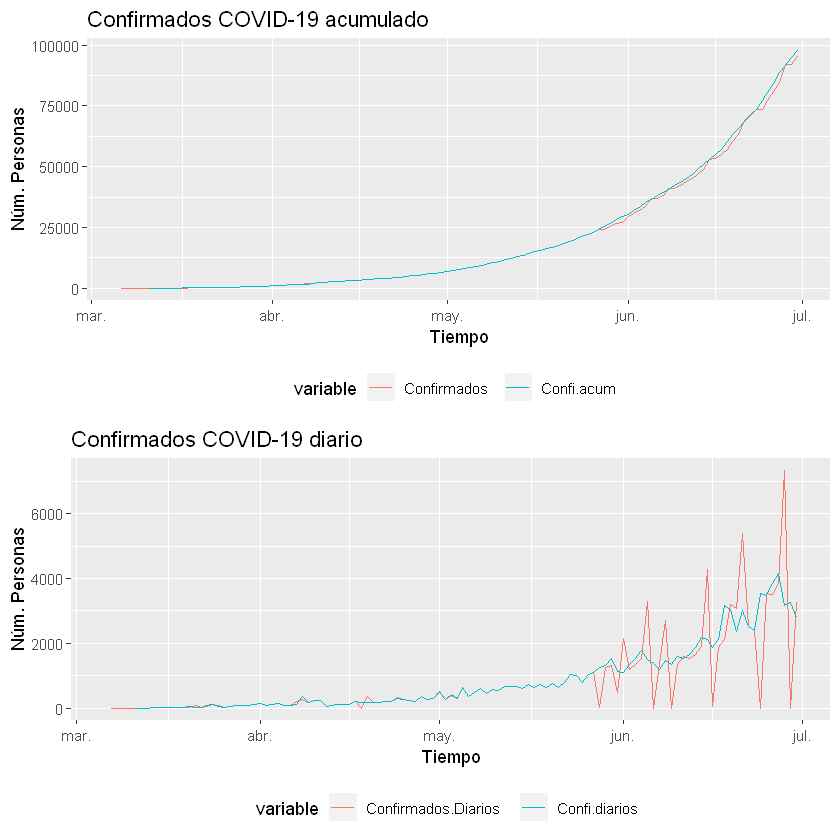

In [20]:
db.count.confi <- db.col %>%
#filter(codigo_divipola == '11001') %>%
group_by(f.repW) %>% 
tally() %>%
mutate(acum = cumsum(n))

db.count.confi$n    <- as.numeric(db.count.confi$n)
db.count.confi$acum <- as.numeric(db.count.confi$acum)

reporte.MS <- db.count.confi
names(reporte.MS) <- c('Tiempo', 'Confi.diarios', 'Confi.acum')

reporte <- left_join(reporte.JH, reporte.MS)

reporte.acum.plot <- melt(data.table(reporte), id.vars = c("Tiempo", "Dias.Transc"),
                          measure.vars = c('Confirmados', 'Confi.acum'))
plot.reporte.acum <- ggplot(reporte.acum.plot, aes(x = Tiempo, y = value, group = variable)) + 
geom_line(aes(color = variable)) + ggtitle(paste('Confirmados COVID-19 acumulado')) + theme(legend.position="bottom") +
labs(y = 'Núm. Personas')


reporte.diario.plot <- melt(data.table(reporte), id.vars = c("Tiempo", "Dias.Transc"),
                            measure.vars = c('Confirmados.Diarios', 'Confi.diarios'))
plot.reporte.diario <- ggplot(reporte.diario.plot, aes(x = Tiempo, y = value, group = variable)) + 
geom_line(aes(color = variable)) + ggtitle(paste('Confirmados COVID-19 diario')) + theme(legend.position="bottom") +
labs(y = 'Núm. Personas')

grid.arrange(plot.reporte.acum, plot.reporte.diario, ncol = 1)

Joining, by = "Tiempo"
Joining, by = "Tiempo"


,Tiempo,Muertos,Confirmados,Recuperados,Activos,Dias.Transc,Confirmados.Diarios
115,2020-06-28,3256,91995,38345,50394,115,7335
116,2020-06-29,3256,91995,38345,50394,116,0
117,2020-06-30,3376,95269,40021,51872,117,3274


Tiempo,Muertos,Confirmados,Recuperados,Activos,Confirmados.diario
2020-06-28,3284,91769,42038,46447,3178
2020-06-29,3330,95043,42073,49640,3274
2020-06-30,3334,97846,42073,52439,2803


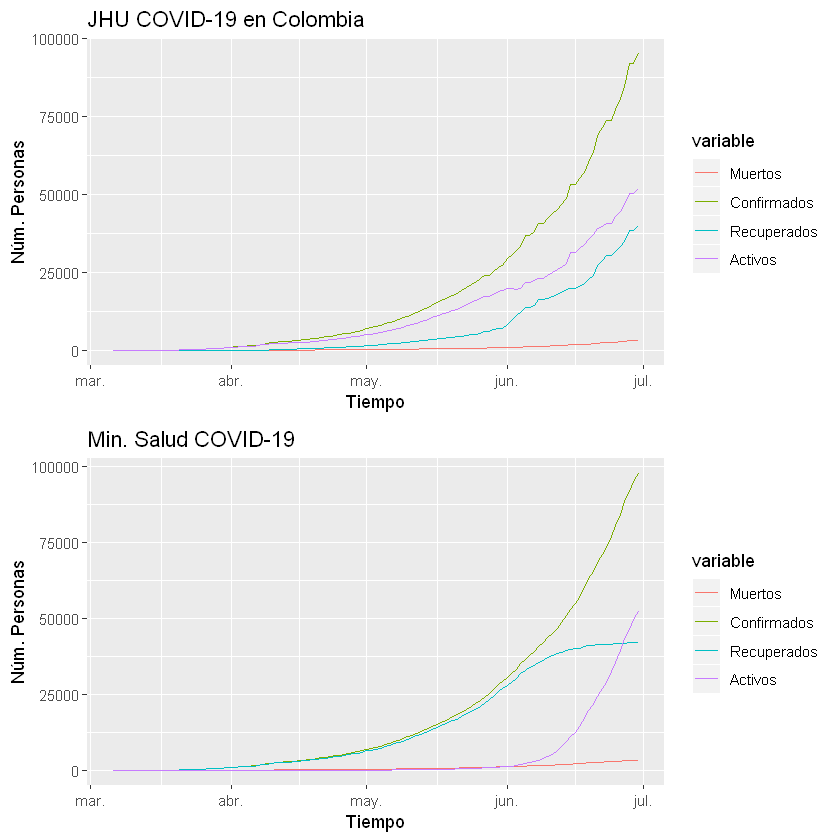

In [21]:
db.count.dead <- db.col %>%
filter(atenci_n %in% c('Fallecido')) %>%
group_by(f.repW) %>% 
tally() 
names(db.count.dead) <- c('Tiempo', 'Muertos.diario')

db.count.recup <- db.col %>%
filter(atenci_n %in% c('Recuperado')) %>%
group_by(f.repW) %>% 
tally()
names(db.count.recup) <- c('Tiempo', 'Recuperados.diario')

names(db.count.confi) <- c('Tiempo', 'Confirmados.diario', 'Confirmados')

tab.MS <- left_join(db.count.confi, db.count.recup)
tab.MS <- left_join(tab.MS, db.count.dead)

tab.MS <- tab.MS %>%
replace_na(list(Recuperados.diario = 0, Muertos.diario = 0))
tab.MS$Activos.diario <- tab.MS$Confirmados.diario - tab.MS$Recuperados.diario - tab.MS$Muertos.diario

tab.MS$Recuperados <- cumsum(tab.MS$Recuperados.diario)
tab.MS$Muertos     <- cumsum(tab.MS$Muertos.diario)
tab.MS$Activos     <- tab.MS$Confirmados - tab.MS$Recuperados - tab.MS$Muertos

tab.MS.plot <- melt(data.table(tab.MS), id.vars = c("Tiempo"),
                    measure.vars = c('Muertos', 'Confirmados', 'Recuperados', 'Activos'))

plot.tab.MS <- ggplot(tab.MS.plot, aes(x = Tiempo, y = value, group = variable)) + 
geom_line(aes(color = variable)) + ggtitle(paste('Min. Salud COVID-19')) + #+ theme(legend.position="bottom")  +
labs(y = 'Núm. Personas')

grid.arrange(info.col.tiempo$plot.covid,plot.tab.MS, ncol = 1)

tail(reporte.JH, 3)
tail(tab.MS[, c('Tiempo','Muertos', 'Confirmados', 'Recuperados', 'Activos', 'Confirmados.diario')], 3)

Warning message:
"Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation..."label_key: ciudad_de_ubicaci_n
label_key: departamento


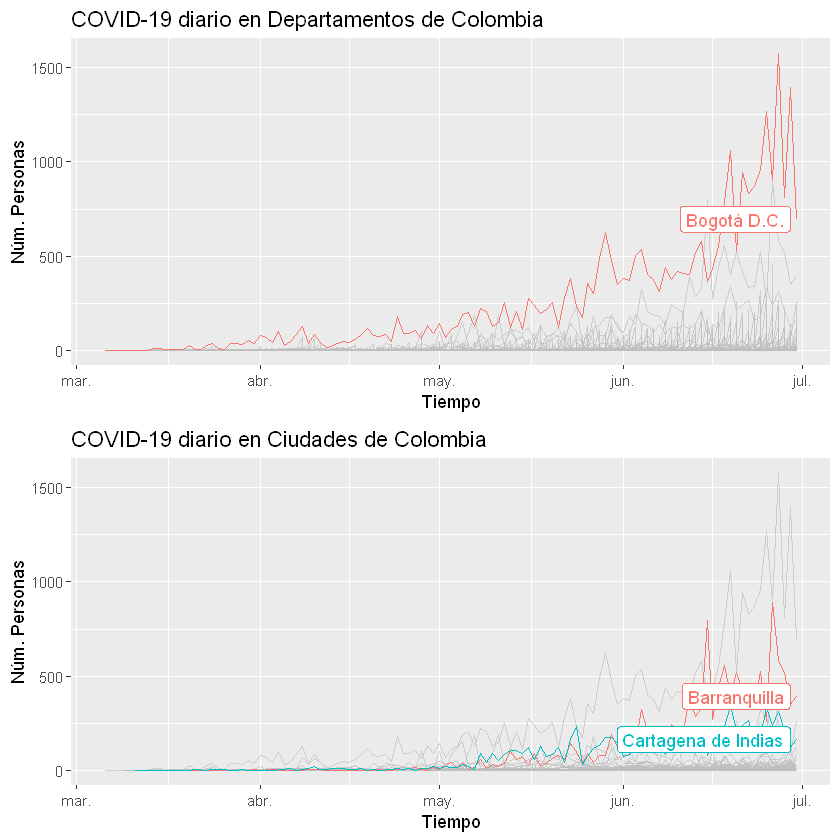

In [22]:
### City ###
db.count.city <- db.col %>%
group_by(f.repW, c_digo_divipola, ciudad_de_ubicaci_n) %>%
tally() 

plot.min.city <- ggplot(db.count.city, aes(x = f.repW, y = n, group = ciudad_de_ubicaci_n)) + 
geom_line(aes(color = ciudad_de_ubicaci_n)) +
ggtitle(paste('COVID-19 diario en Ciudades de Colombia'))  +
labs(y = 'Núm. Personas', x = 'Tiempo') +
gghighlight(ciudad_de_ubicaci_n %in% c('Barranquilla', 'Cartagena de Indias'))
#gghighlight(max(n) > 200, use_direct_label = FALSE) 
#gghighlight(max(n) > 200) 
 
### Departament ###
db.count.dep <- db.col %>%
group_by(f.repW, c_digo_divipola, departamento) %>%
tally() 

plot.min.dep <- ggplot(db.count.dep, aes(x = f.repW, y = n, group = departamento)) + 
geom_line(aes(color = departamento)) +
ggtitle(paste('COVID-19 diario en Departamentos de Colombia'))  +
labs(y = 'Núm. Personas', x = 'Tiempo') +
#gghighlight(ciudad_de_ubicaci_n %in% c('Barranquilla', 'Cartagena de Indias'))
#gghighlight(max(n) > 200, use_direct_label = FALSE) 
gghighlight(max(n) > 1500) 

grid.arrange(plot.min.dep, plot.min.city, ncol = 1)

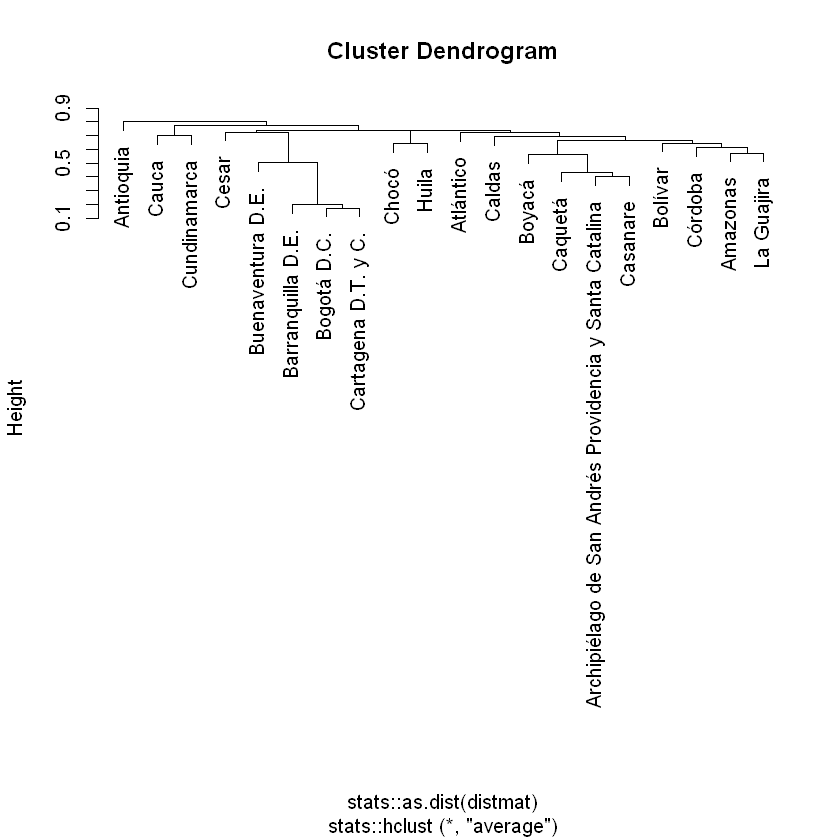

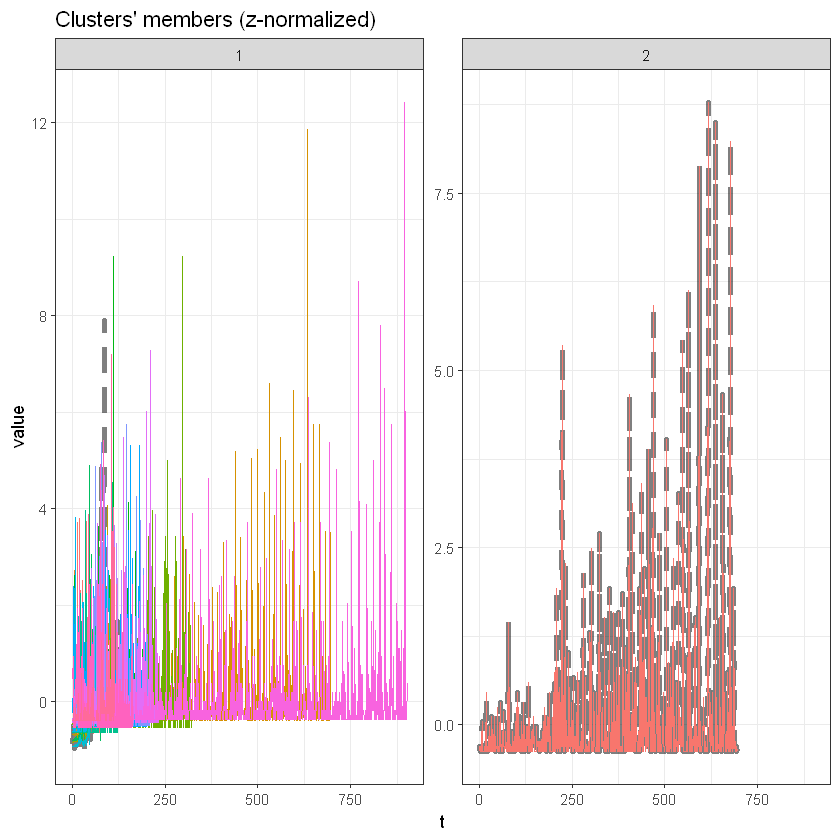

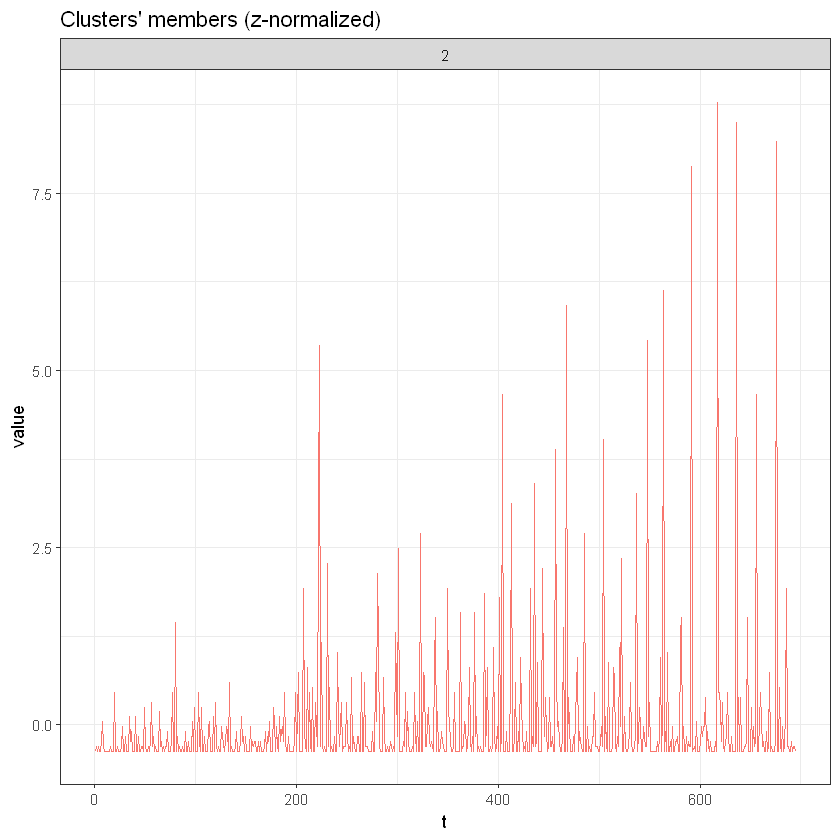

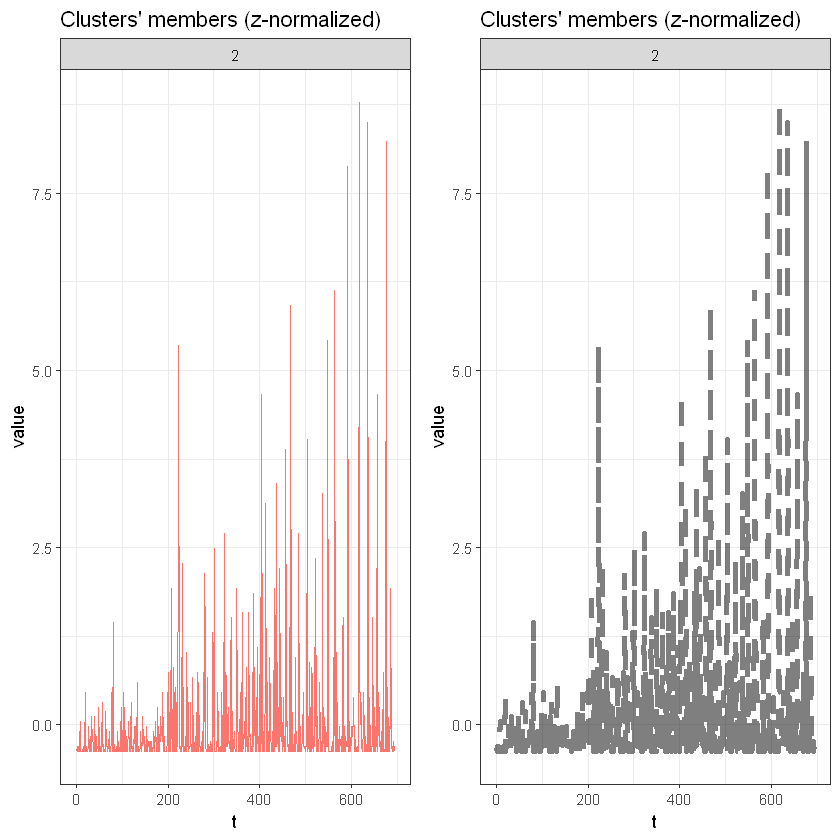

In [23]:
# install.packages('tsclust')
# http://r-es.org/9jornadasR/pdf/9JUR_paper_24.pdf
# https://cran.r-project.org/web/packages/dtwclust/vignettes/dtwclust.pdf

tabla.lista <- list()
for( ii in names(table(db.count.dep$departamento)) ) {
    if( !(ii %in% c('Guainía', 'Guaviare', 'Vaupés', 'Vichada', 'Arauca')) ){
        tabla.lista[ii] <- db.count.dep[db.count.dep$departamento == ii, c('n')]        
    }    
}
    

hc.dep <- tsclust(tabla.lista[1L:20L], type = "h", k = 2L,
                  preproc = zscore, seed = 899,
                  distance = "sbd", centroid = shape_extraction,
                  control = hierarchical_control(method = "average"))

# By default, the dendrogram is plotted in hierarchical clustering
plot(hc.dep)

plot(hc.dep, type = "sc")

# Focusing on the first cluster
grid.arrange(plot(hc.dep, type = "series", clus = 2L), plot(hc.dep, type = "centroids", clus = 2L), ncol = 2)


List of 100
 $ A.V1: num [1:178] 0 0 0 -0.0332 -0.0575 ...
 $ A.V2: num [1:178] 0 0 0 -0.0485 -0.0739 ...
 $ A.V3: num [1:178] 0 0 0 -0.0262 -0.0375 ...
 $ A.V4: num [1:178] 0 0 0 0 0 ...
 $ A.V5: num [1:178] 0 0 0 0 0 ...
 $ B.V1: num [1:174] 0 0 0 0 0 ...
 $ B.V2: num [1:174] 0 0 0 0 0 0 0 0 0 0 ...
 $ B.V3: num [1:174] 0 0 0 0 0 0 0 0 0 0 ...
 $ B.V4: num [1:174] 0 0 0 0 0 ...
 $ B.V5: num [1:174] 0 0 0 0 0 0 0 0 0 0 ...
 $ C.V1: num [1:130] 0 0 0 0.272 0.312 ...
 $ C.V2: num [1:130] 0 0 0 0 0 ...
 $ C.V3: num [1:130] 0 0 0 0 0 0 0 0 0 0 ...
 $ C.V4: num [1:130] 0 0 0 0 -0.0321 ...
 $ C.V5: num [1:130] 0 0 0 0.00451 0.01066 ...
 $ D.V1: num [1:160] 0 0 0 0 0 ...
 $ D.V2: num [1:160] 0 0 0 0 0 0 0 0 0 0 ...
 $ D.V3: num [1:160] 0 0 0 0 0 ...
 $ D.V4: num [1:160] 0 0 0 0 0 0 0 0 0 0 ...
 $ D.V5: num [1:160] 0 0 0 0 0 0 0 0 0 0 ...
 $ E.V1: num [1:174] 0 0 0 0.0053 -0.0254 ...
 $ E.V2: num [1:174] 0 0 0 0.000142 0.000694 ...
 $ E.V3: num [1:174] 0 0 0 0 0 0 0 0 0 0 ...
 $ E.V4: num [1:

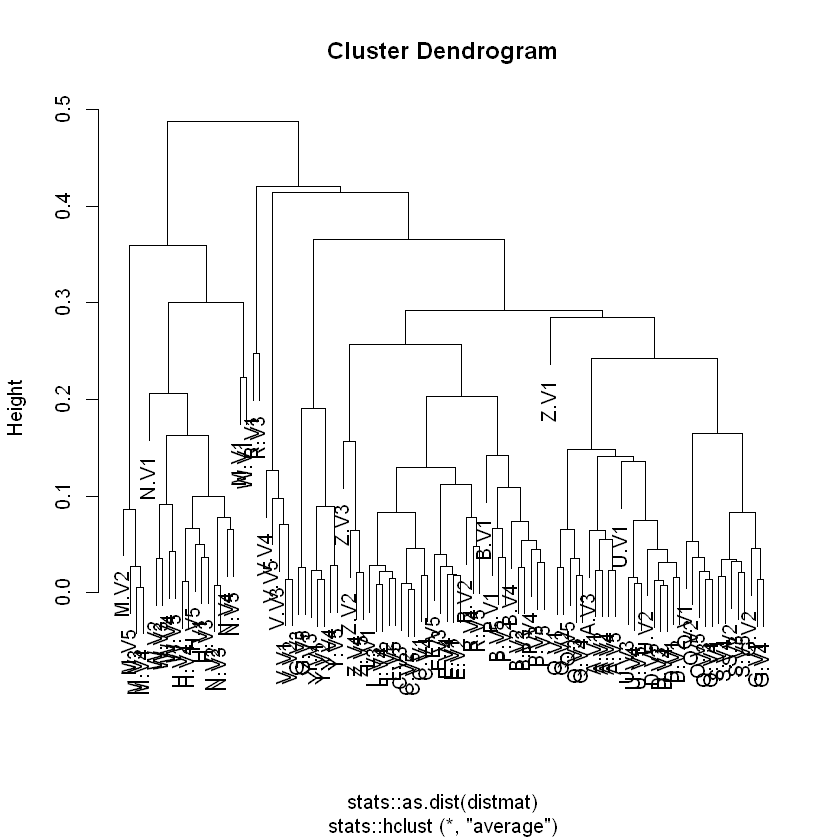

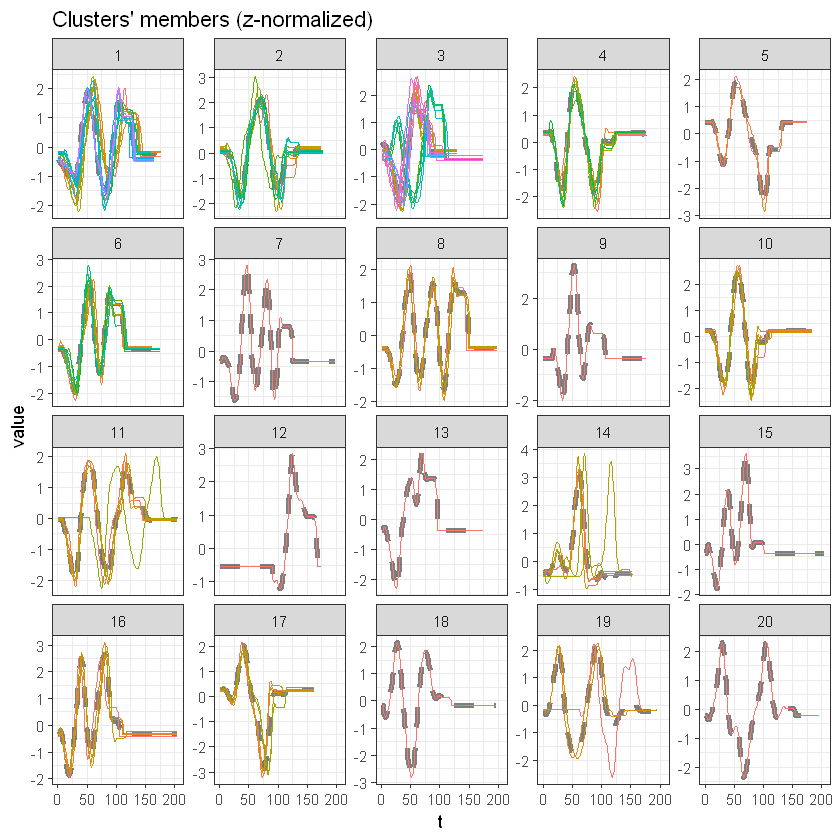

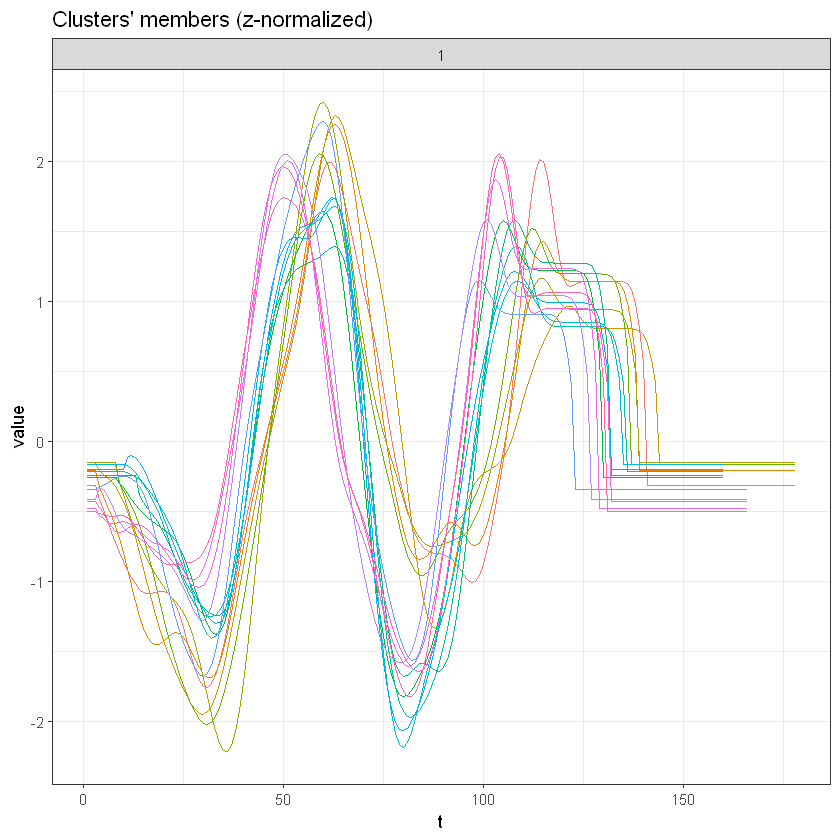

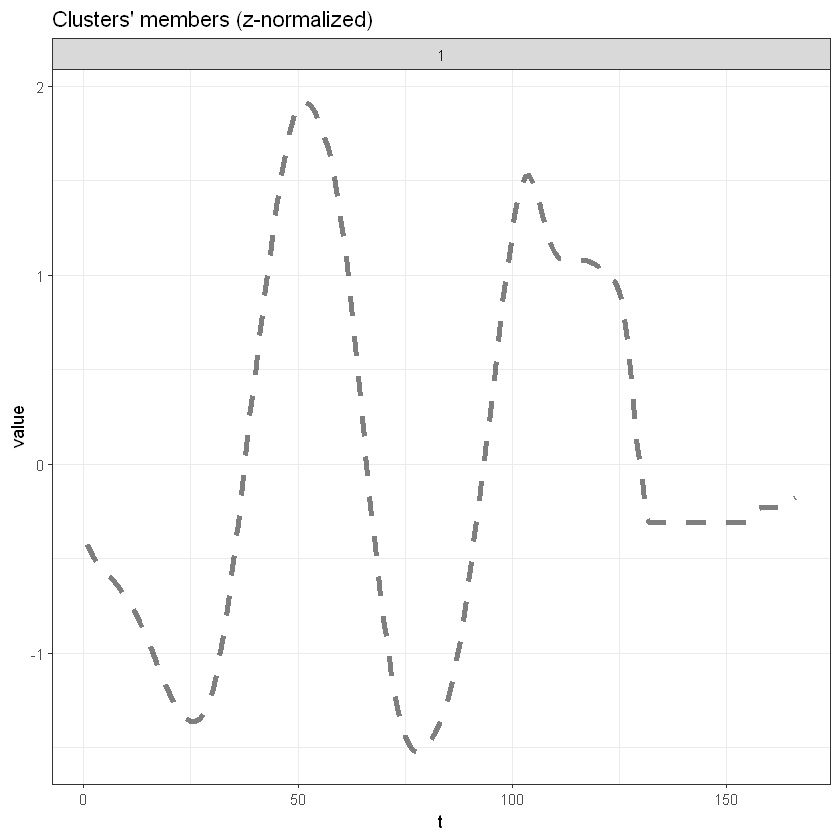

In [10]:
#library(dtwclust)

str(CharTraj)

hc_sbd <- tsclust(CharTraj, type = "h", k = 20L,
                  preproc = zscore, seed = 899,
                  distance = "sbd", centroid = shape_extraction,
                  control = hierarchical_control(method = "average"))

# By default, the dendrogram is plotted in hierarchical clustering
plot(hc_sbd)

# The series and the obtained prototypes can be plotted too
plot(hc_sbd, type = "sc")

# Focusing on the first cluster
plot(hc_sbd, type = "series", clus = 1L)
plot(hc_sbd, type = "centroids", clus = 1L)
